# HNCDI Explain: Mathematical Fundamentals of Quantum Computing

## Tutorial 2: Estimate $\pi$ using quantum algorithms

In [3]:
# Default imports
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.compiler import transpile
from qiskit.visualization import *

from ibm_quantum_widgets import *

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit_ibm_provider import IBMProvider

# # Loading your IBM Quantum account(s) # Remove comment for IBM Quantum Online
provider = IBMProvider() # loads account from env variables

In [6]:
# Notebook imports
from qiskit_ibm_provider import least_busy

# pi approximation
from qiskit import assemble
from qiskit_ibm_provider.job import job_monitor
import matplotlib.pyplot as plt

In [7]:
# Set simulator backend
simulator_backend = AerSimulator()

## Approximating $\pi$ 

In [8]:
#Compute the Inverse Quantum Fourier Transform

def qft_dagger(circ_, n_qubits):
    """n-qubit QFTdagger the first n qubits in circ"""
    for qubit in range(int(n_qubits/2)):
        circ_.swap(qubit, n_qubits-qubit-1)
    for j in range(0,n_qubits):
        for m in range(j):
            circ_.cp(-np.pi/float(2**(j-m)), m, j)
        circ_.h(j)

In [9]:
#Initial state of Quantum Phase Estimation

def qpe_pre(circ_, n_qubits):
    circ_.h(range(n_qubits))
    circ_.x(n_qubits)

    for x in reversed(range(n_qubits)):
        for _ in range(2**(n_qubits-1-x)):
            circ_.cp(1, n_qubits-1-x, n_qubits)

In [10]:
def run_job(circ, backend, shots, optimization_level=0):
    t_circ = transpile(circ, backend, optimization_level=optimization_level)
    qobj = assemble(t_circ, shots=shots)
    job = backend.run(qobj)
    job_monitor(job)
    return job.result().get_counts()

In [11]:
def get_pi_estimate(n_qubits, backend, shots):
        
    # create the circuit
    circ = QuantumCircuit(n_qubits + 1, n_qubits)
    
    # create the input state
    qpe_pre(circ, n_qubits)
        
    # apply a barrier
    circ.barrier()
    # apply the inverse fourier transform
    qft_dagger(circ, n_qubits)
    # apply  a barrier
    circ.barrier()
    # measure all but the last qubits
    circ.measure(range(n_qubits), range(n_qubits))
    
    # optionally save to a file
    if n_qubits == 3:
        circ.draw(filename='qpe')

    # run the job and get the results
    counts = run_job(circ, backend, shots, optimization_level=0)
    print('counts = ', counts) 

    # get the count that occurred most frequently
    max_counts_result = max(counts, key=counts.get)
    print('max_counts_result = ', max_counts_result)
    max_counts_result = int(max_counts_result, 2)
    print('max_counts_result = ', max_counts_result)
    
    # solve for pi from the measured counts
    theta = max_counts_result/2**n_qubits
    return (1./(2*theta))

In [16]:
# estimate pi using different numbers of qubits

number_of_shots = 1024 # Add a number of shots
upper_limit_qubits = 13 # Add an upper limit of qubits
nqs = list(range(2,upper_limit_qubits+1))
pi_estimates = []
for nq in nqs:
    thisnq_pi_estimate = get_pi_estimate(nq, simulator_backend, number_of_shots)
    pi_estimates.append(thisnq_pi_estimate)
    print(f"{nq} qubits, pi ≈ {thisnq_pi_estimate}")

/tmp/ipykernel_186/2817239088.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


Job Status: job has successfully run
counts =  {'11': 58, '10': 70, '00': 205, '01': 691}
max_counts_result =  01
max_counts_result =  1
2 qubits, pi ≈ 2.0
Job Status: job has successfully run
counts =  {'101': 12, '111': 11, '011': 21, '100': 14, '110': 12, '000': 37, '010': 117, '001': 800}
max_counts_result =  001
max_counts_result =  1
3 qubits, pi ≈ 4.0
Job Status: job has successfully run
counts =  {'1010': 2, '1011': 4, '0011': 475, '0111': 11, '1100': 7, '0010': 357, '0000': 21, '1000': 7, '0110': 12, '1101': 7, '0100': 41, '0001': 42, '1111': 11, '1001': 4, '0101': 19, '1110': 4}
max_counts_result =  0011
max_counts_result =  3
4 qubits, pi ≈ 2.6666666666666665
Job Status: job has successfully run
counts =  {'01001': 1, '00010': 1, '00110': 6, '11111': 1, '00100': 11, '00111': 1, '00011': 3, '01011': 2, '11100': 1, '00101': 997}
max_counts_result =  00101
max_counts_result =  5
5 qubits, pi ≈ 3.2
Job Status: job has successfully run
counts =  {'010111': 1, '000000': 1, '001111

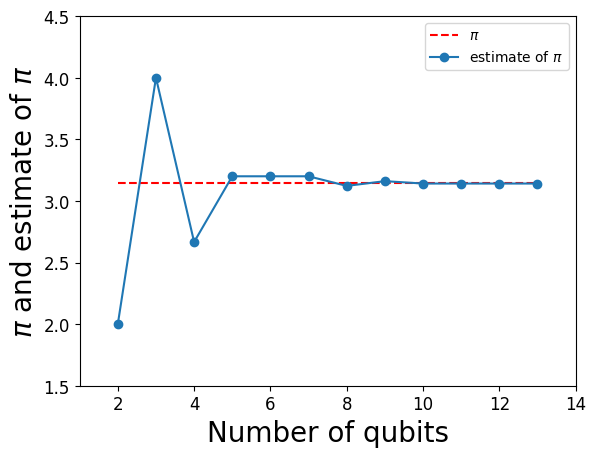

In [17]:
pi = np.pi

plt.plot(nqs, [pi]*len(nqs), '--r')
plt.plot(nqs, pi_estimates, '.-', markersize=12)
plt.xlim([nqs[0]-1,nqs[-1]+1])
plt.ylim([1.5, 4.5])
plt.legend(['$\pi$', 'estimate of $\pi$'])
plt.xlabel('Number of qubits', fontdict={'size':20})
plt.ylabel('$\pi$ and estimate of $\pi$', fontdict={'size':20})
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.show()